# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
 

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias_rows,azdias_columns=azdias.shape
feat_info_rows,feat_info_columns=feat_info.shape
print("number of rows in AZDIAS dataset :{}".format(azdias_rows),"\n"
      "number of columns in AZDIAS :{}".format(azdias_columns))

print("number of rows in Feature Summary :{}".format(feat_info_rows),"\n"
      "number of columns in Feature Summary :{}".format(feat_info_columns))

number of rows in AZDIAS dataset :891221 
number of columns in AZDIAS :85
number of rows in Feature Summary :85 
number of columns in Feature Summary :4


In [4]:
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


In [8]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
azdias.isna().sum().sum()


4896838

In [10]:
print(f'Out of all the {azdias.shape[0]*azdias.shape[1]} values in the data frame, {azdias.isna().sum().sum()} ones \
or {((azdias.isna().sum().sum())/(azdias.shape[0]*azdias.shape[1]))*100:.2f}% are naturally missing')

Out of all the 75753785 values in the data frame, 4896838 ones or 6.46% are naturally missing


In [11]:
feat_info['missing_or_unknown_list'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

feat_info.T

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
information_level,person,person,person,person,person,person,person,person,person,person,...,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,community,community,community
type,categorical,ordinal,categorical,categorical,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,...,ordinal,ordinal,ordinal,ordinal,mixed,ordinal,ordinal,ordinal,ordinal,ordinal
missing_or_unknown,"[-1,0]","[-1,0,9]","[-1,0]",[0],[-1],[-1],[-1],[-1],[-1],[-1],...,[-1],[-1],[-1],[-1],"[-1,0]",[-1],[-1],"[-1,9]","[-1,0]","[-1,9]"
missing_or_unknown_list,"[-1, 0]","[-1, 0, 9]","[-1, 0]",[0],[-1],[-1],[-1],[-1],[-1],[-1],...,[-1],[-1],[-1],[-1],"[-1, 0]",[-1],[-1],"[-1, 9]","[-1, 0]","[-1, 9]"


In [12]:
# Identify missing or unknown data values and convert them to NaNs.

for attribute,missing_values_list in zip(feat_info["attribute"], feat_info["missing_or_unknown_list"]):
    if missing_values_list[0] != "": # if the list not empty 
        for missing_value in missing_values_list:
            if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                missing_value = int(missing_value)
            azdias.loc[azdias[attribute] == missing_value, attribute] = np.nan
            

In [13]:
azdias

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,NaN,3.0,2.0,5.0,1.0,4.0,2.0,5.0,4.0,4.0,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,NaN,2.0,1.0,4.0,3.0,3.0,3.0,2.0,2.0,3.0,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,NaN,2.0,2.0,4.0,2.0,4.0,2.0,5.0,4.0,3.0,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,NaN,1.0,1.0,3.0,1.0,5.0,3.0,5.0,5.0,5.0,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missing_data = azdias.isnull().sum()
missing_data.sort_values(ascending=True, inplace=True)


In [15]:
# Get Percentage
missing_data = missing_data/(azdias.shape[0])*100
missing_data

ZABEOTYP          0.000000
SEMIO_TRADV       0.000000
SEMIO_PFLICHT     0.000000
SEMIO_KAEM        0.000000
SEMIO_DOM         0.000000
                   ...    
GEBURTSJAHR      44.020282
KBA05_BAUMAX     53.468668
KK_KUNDENTYP     65.596749
AGER_TYP         76.955435
TITEL_KZ         99.757636
Length: 85, dtype: float64

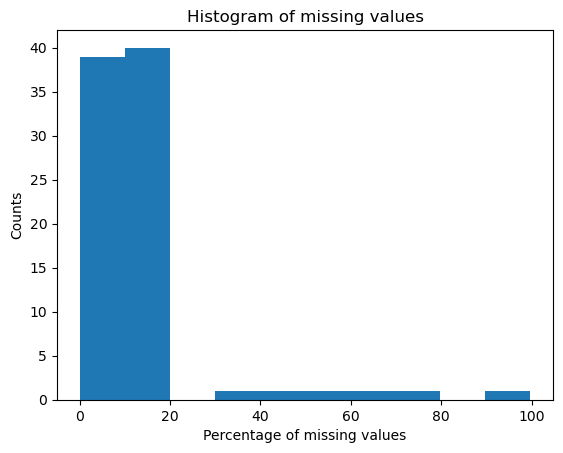

In [16]:
#using hist() function to plot histogram for each column in dataset

plt.hist(missing_data)

plt.xlabel('Percentage of missing values')
plt.ylabel('Counts')
plt.title('Histogram of missing values')
plt.show()

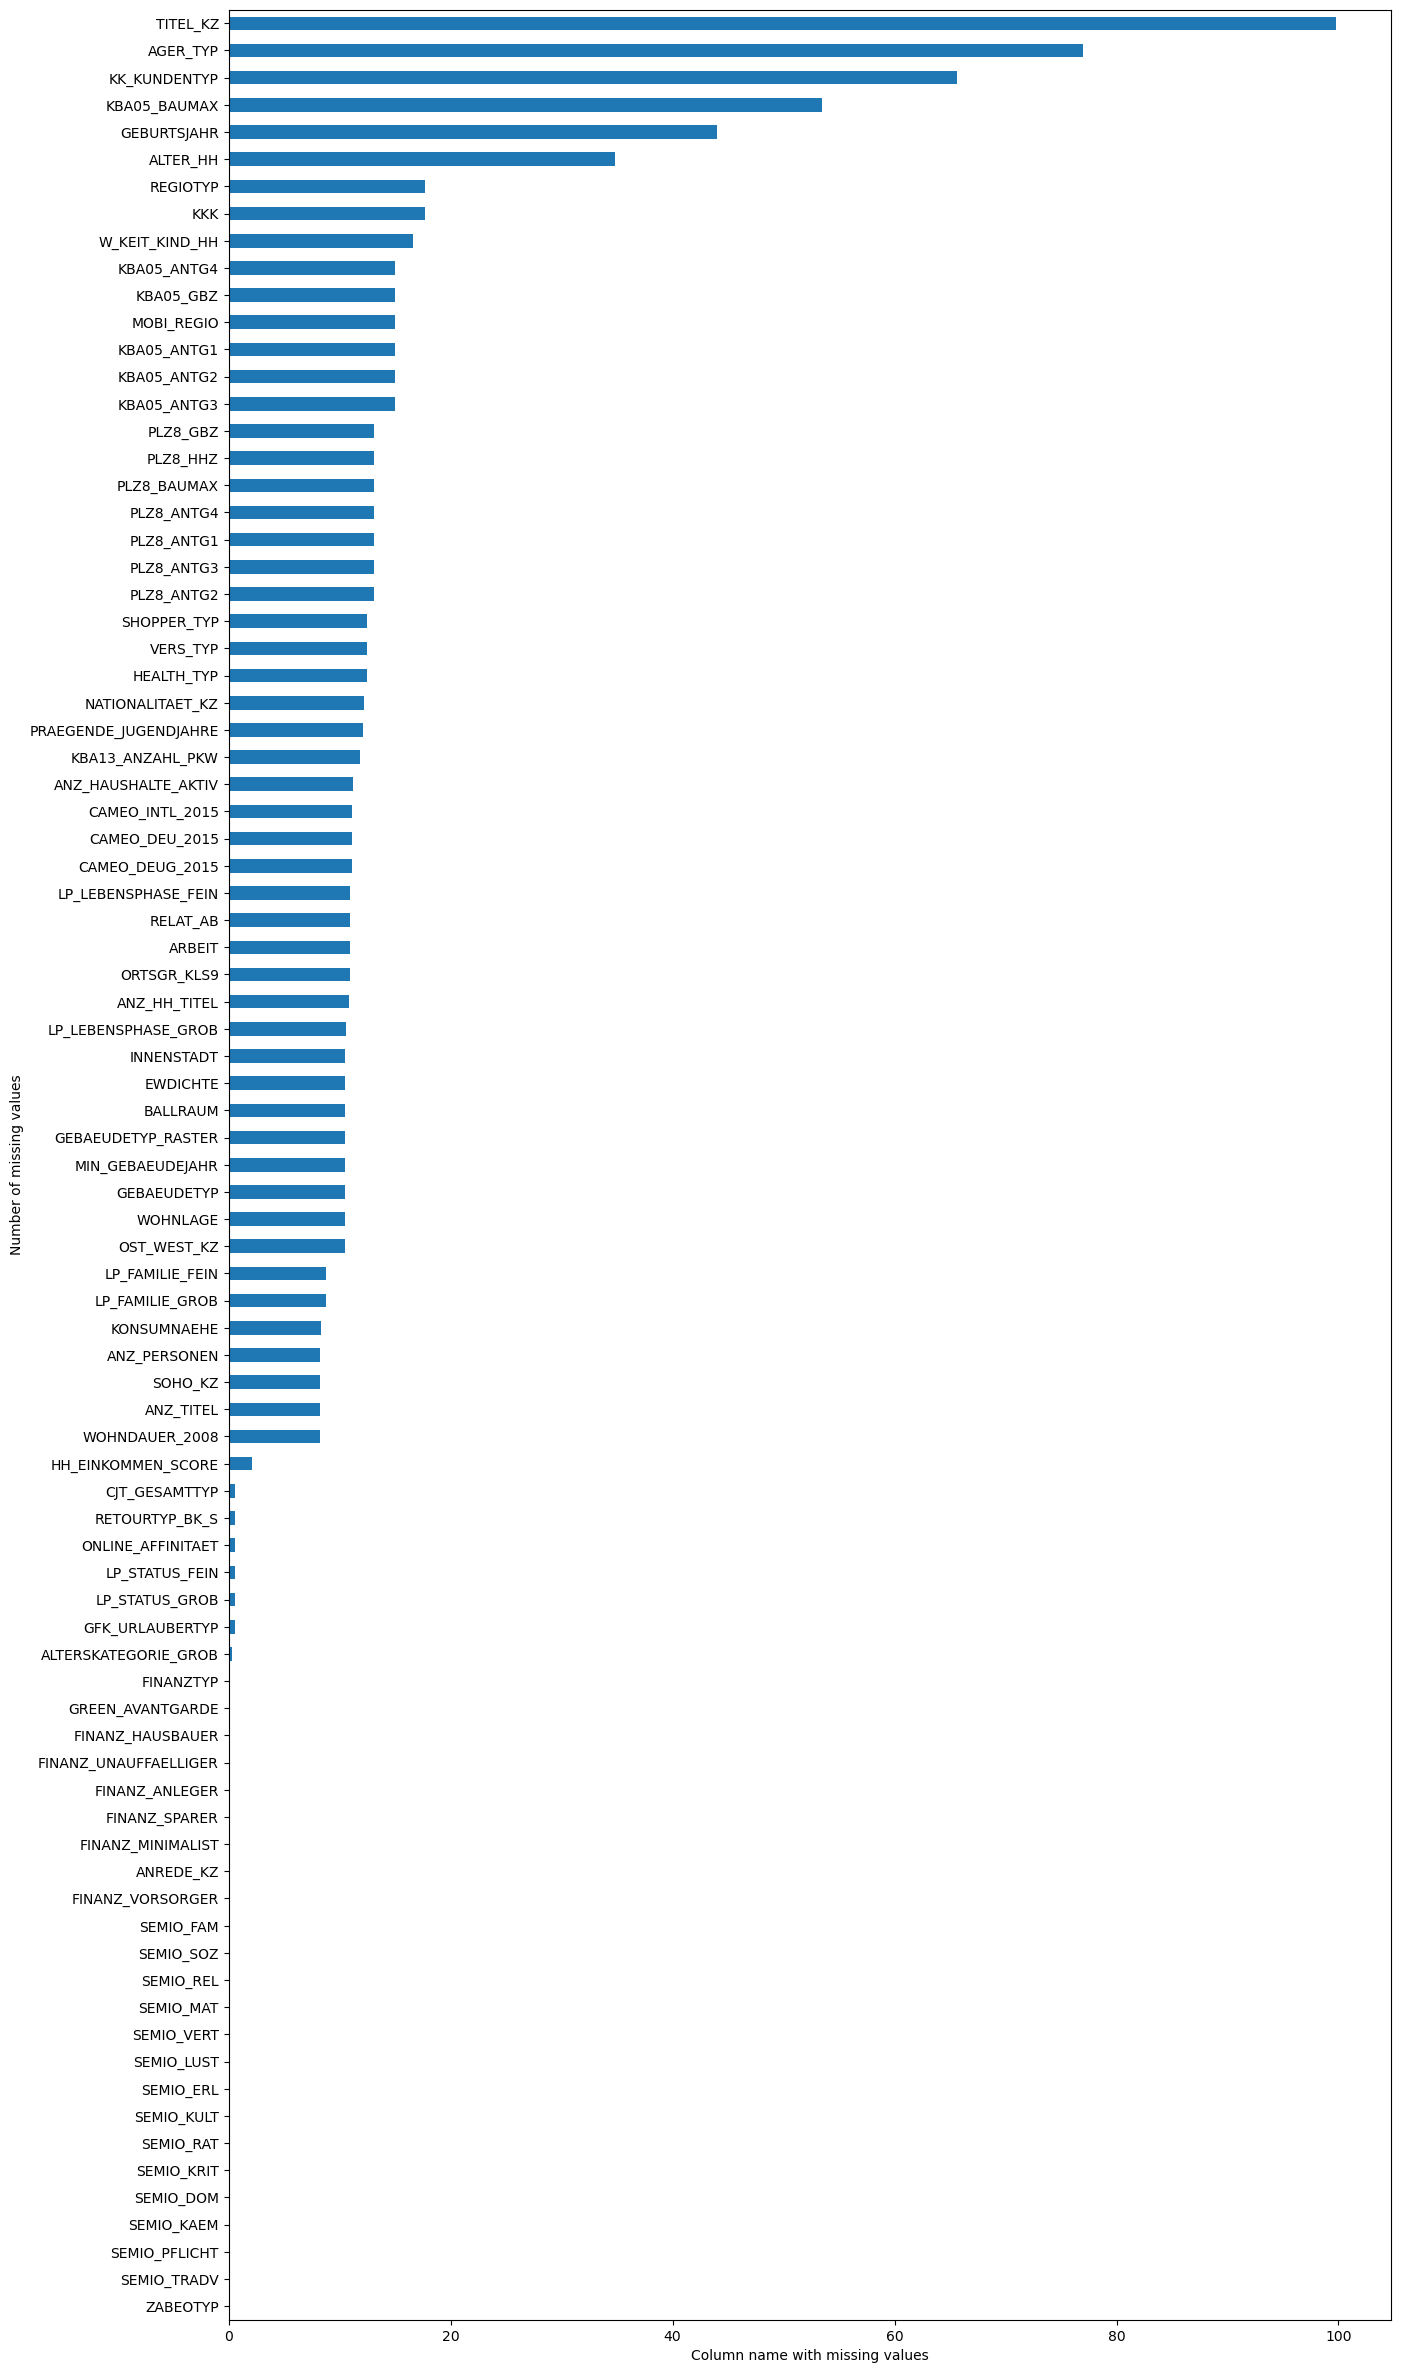

In [17]:
# Investigate patterns in the amount of missing data in each column.
missing_data.plot.barh(figsize=(15,30))
plt.xlabel('Column name with missing values')
plt.ylabel('Number of missing values')

plt.show()

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_columns = missing_data[missing_data>20].index
azdias.drop(columns=outlier_columns,axis="columns",inplace=True)




In [19]:
print(outlier_columns) 

Index(['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'],
      dtype='object')


In [20]:
(azdias.isna().sum()==0).sum()

24

In [21]:
azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,6.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

### Ans
### method 1
Columns are separated in two groups, the columns which have less than 20% of missing values and the columns that have more than 20%.
24 columns have no missing values.
Therefore, columns that have more than 20% missing data are considered as outlier columns, and are dropped.
And outlier columns are ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP','TITEL_KZ'


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

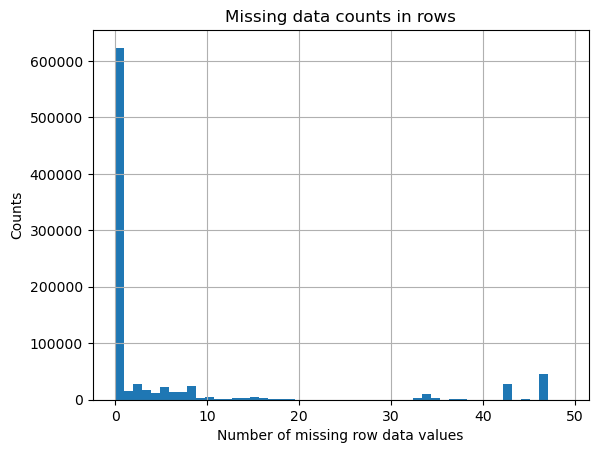

In [22]:
# How much data is missing in each row of the dataset?

missing_row_data = azdias.isnull().sum(axis=1)

plt.hist(missing_row_data, bins=50)


plt.xlabel('Number of missing row data values')
plt.ylabel('Counts')
plt.title('Missing data counts in rows')
plt.grid(True)
plt.show()


In [23]:
missing_row_data

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

missing_less_30 = azdias[missing_row_data < 30].reset_index(drop=True)
missing_above_30 = azdias[missing_row_data >= 30].reset_index(drop=True)

In [25]:
missing_less_30.describe()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,795258.000000,798061.000000,793316.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793834.000000,793935.000000,793834.000000
mean,2.795412,1.521485,3.502893,3.058917,2.716047,3.432892,2.840955,2.658348,3.114102,3.797751,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166687,5.293396,3.071035
std,1.018409,0.499538,1.537612,1.377577,1.485090,1.376866,1.472782,1.399530,1.408109,2.084705,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999070,2.303377,1.360535
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,4.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,6.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [26]:
missing_above_30.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,93082.000000,93160.000000,93051.000000,93160.000000,93160.000000,93160.000000,93160.000000,93160.000000,93160.000000,93160.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.000000,12.000000,12.000000
mean,2.430889,1.527351,4.740701,3.208265,3.720459,3.128811,4.681312,4.722993,2.741187,3.729208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.083333,4.833333,2.916667
std,0.868609,0.499254,1.645007,0.646951,0.853282,0.632291,0.876499,0.741143,0.639537,0.754508,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.164500,2.480225,1.240112
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2.000000,1.000000
25%,2.000000,1.000000,4.000000,3.000000,4.000000,3.000000,5.000000,5.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,3.000000,2.000000
50%,3.000000,2.000000,6.000000,3.000000,4.000000,3.000000,5.000000,5.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,4.000000,3.000000
75%,3.000000,2.000000,6.000000,3.000000,4.000000,3.000000,5.000000,5.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,5.750000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,9.000000,5.000000


In [27]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

top_few_missing_cols=missing_data[missing_data < 30].index[:5]
top_few_missing_cols


Index(['ZABEOTYP', 'SEMIO_TRADV', 'SEMIO_PFLICHT', 'SEMIO_KAEM', 'SEMIO_DOM'], dtype='object')

In [28]:
len(missing_less_30) / len(azdias)


0.895469249490306

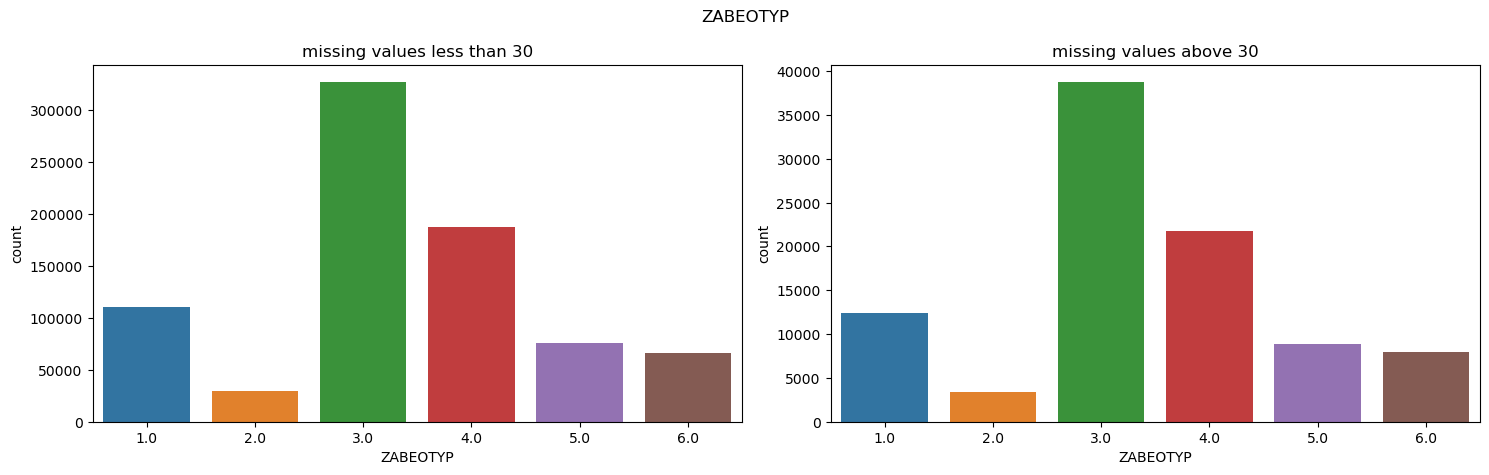

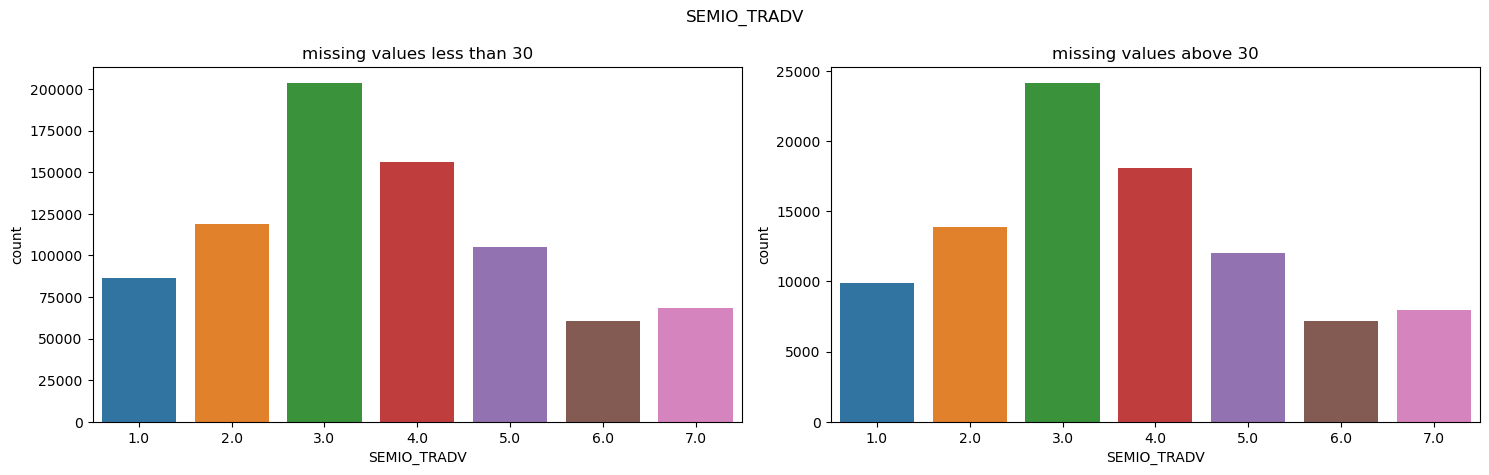

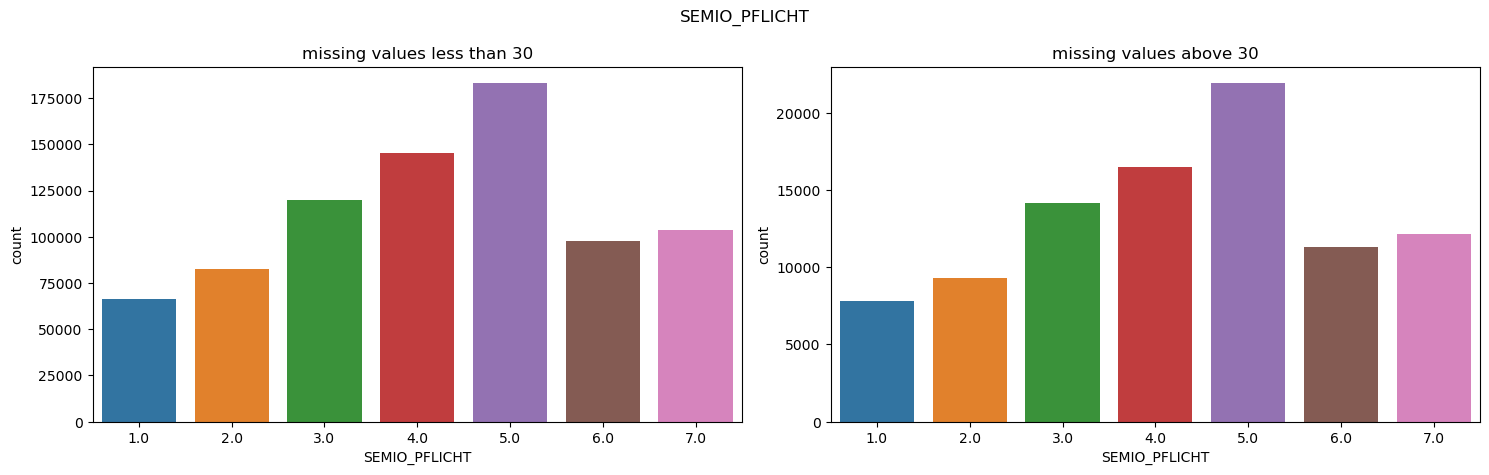

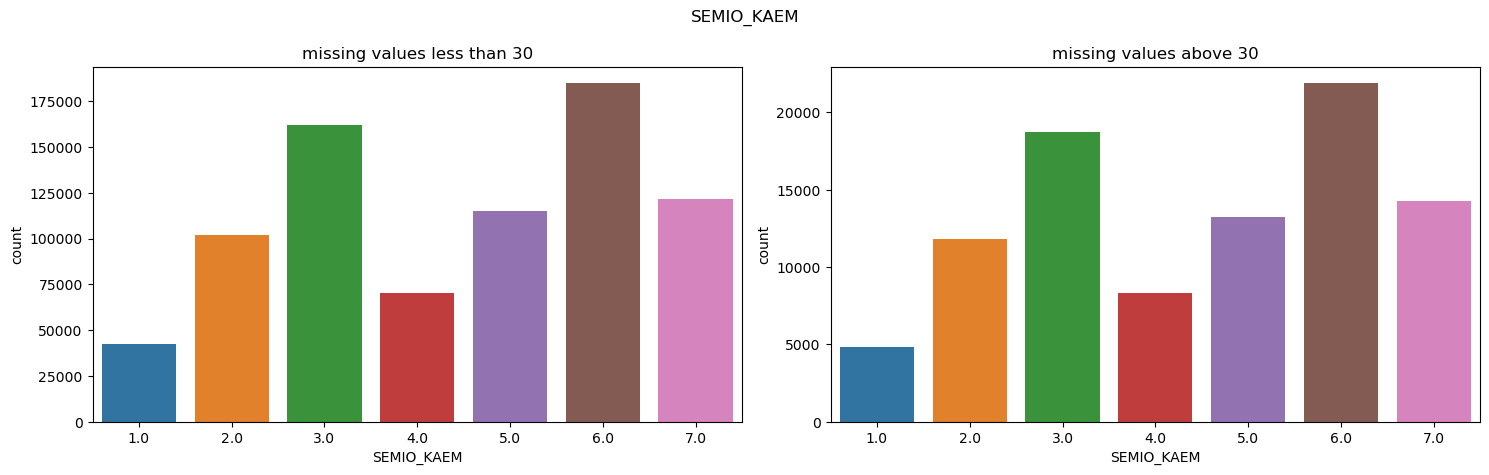

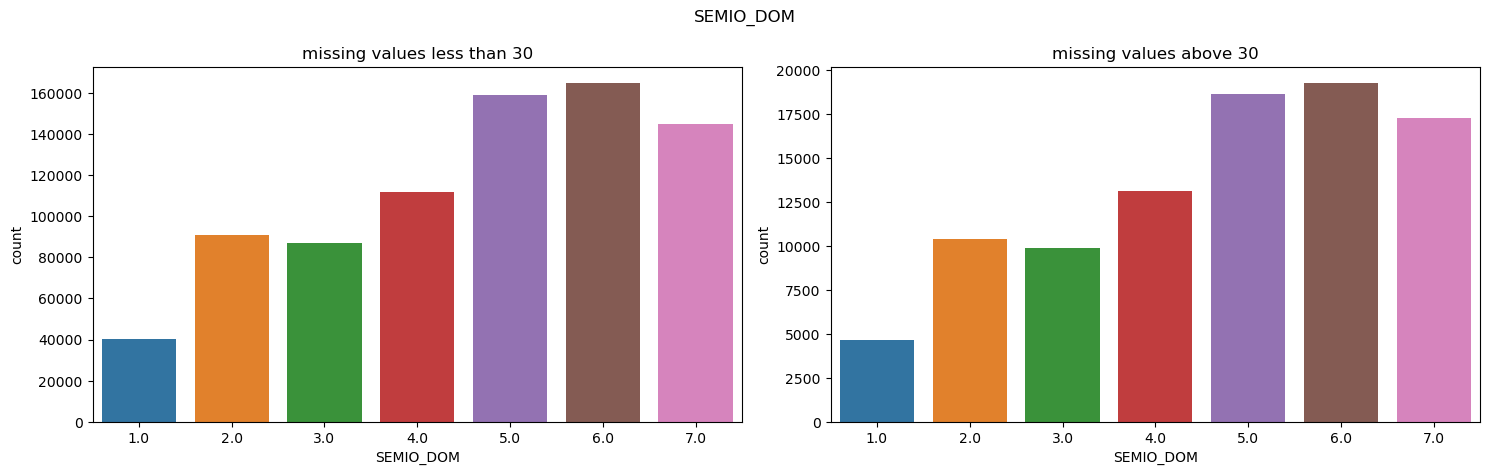

In [29]:
def create_plot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('missing values less than 30')
    sns.countplot(x=azdias.loc[missing_less_30.index,column],ax=ax1)

    ax2.set_title('missing values above 30')
    sns.countplot(x=azdias.loc[missing_above_30.index,column],ax=ax2)
    
    fig.suptitle(column)
    plt.tight_layout()
    plt.show()
for i in range(top_few_missing_cols.size):
    create_plot(top_few_missing_cols[i])

In [30]:
# selecting rows with high missing values
azdias_high_missing = azdias.iloc[missing_above_30.index]

print(f'Total rows in azdias dataset is {azdias.shape[0]}')

# dropping rows with high missing values
azdias = azdias[~azdias.index.isin(missing_above_30.index)]
azdias.head()

print(f'{len(azdias_high_missing)} rows greater than 30% in missing row values were dropped')
print(f'{azdias.shape[0]} rows are remaining')

Total rows in azdias dataset is 891221
93160 rows greater than 30% in missing row values were dropped
798061 rows are remaining


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)
#### Answer
We separate the data in two datasets, the first one data with less than 30 columns null and the second one with 30 or more columns null, then we plot them on the columns with less or any missing values that are: ['ZABEOTYP', 'SEMIO_TRADV', 'SEMIO_PFLICHT', 'SEMIO_KAEM', 'SEMIO_DOM'].
From the charts above, the distributions of values between the two datasets are very much simiral.So simply dropping those points from the analysis won't present a major issue

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [31]:
# How many features are there of each data type?

feat_info['type'].value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [32]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_features = feat_info[feat_info.type == 'categorical'].attribute
categorical_features = categorical_features[ ~categorical_features.isin(outlier_columns)]

print(categorical_features)


2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


In [33]:
binary_features = []
multi_level_columns = []

for col in categorical_features:
    if azdias[col].nunique()==2:
        binary_features.append(col)
    else:
        multi_level_columns.append(col)

In [34]:
# Binary catagorical variables

for feature in binary_features:
    print(azdias[feature].value_counts())

2.0    416483
1.0    381578
Name: ANREDE_KZ, dtype: int64
0    640911
1    157150
Name: GREEN_AVANTGARDE, dtype: int64
0.0    726425
1.0      6170
Name: SOHO_KZ, dtype: int64
2.0    356877
1.0    342022
Name: VERS_TYP, dtype: int64
W    562845
O    152061
Name: OST_WEST_KZ, dtype: int64


In [35]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

for column in multi_level_columns:
    print(azdias[column].value_counts())
'''
encoded_azdias = azdias2.copy()

encoded_azdias['ANREDE_KZ'].replace([2.0, 1], [1.0, 0], inplace=True)
encoded_azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
encoded_azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
# Check
for feature in binary_features:
    print(encoded_azdias[feature].value_counts())
'''    

C:\Users\gagka\AppData\Local\Temp\ipykernel_29620\3781556318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
C:\Users\gagka\AppData\Local\Temp\ipykernel_29620\3781556318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
C:\Users\gagka\AppData\Local\Temp\ipykernel_29620\3781556318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

4.0    188953
3.0    140168
6.0    137566
2.0    133326
5.0    105194
1.0     88513
Name: CJT_GESAMTTYP, dtype: int64
6.0    260198
1.0    178343
4.0    116719
2.0     99508
5.0     95227
3.0     48066
Name: FINANZTYP, dtype: int64
12.0    124178
5.0     107336
10.0     97619
8.0      78561
11.0     71440
4.0      57238
9.0      54315
3.0      50145
1.0      47877
2.0      42009
7.0      38639
6.0      24363
Name: GFK_URLAUBERTYP, dtype: int64
1.0     381733
10.0    123575
2.0      93416
11.0     46265
8.0      20771
7.0      18615
4.0      11057
5.0      10743
9.0      10026
6.0       8089
3.0       4403
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    381733
5.0    179866
2.0     93416
4.0     47475
3.0     26203
Name: LP_FAMILIE_GROB, dtype: int64
1.0     195808
9.0     128851
10.0    106033
2.0     105773
4.0      70198
5.0      66433
3.0      66105
6.0      27759
8.0      17751
7.0       9009
Name: LP_STATUS_FEIN, dtype: int64
1.0    301581
2.0    202736
4.0    146602
5.0    106033
3.0 

"\nencoded_azdias = azdias2.copy()\n\nencoded_azdias['ANREDE_KZ'].replace([2.0, 1], [1.0, 0], inplace=True)\nencoded_azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)\nencoded_azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)\n# Check\nfor feature in binary_features:\n    print(encoded_azdias[feature].value_counts())\n"

In [36]:
# Multi-level categorical variables
azdias=pd.get_dummies(data=azdias,columns=multi_level_columns)


In [37]:
azdias.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
93160,4.0,1.0,5.0,1.0,4.0,2.0,1.0,4.0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
93161,3.0,0.0,5.0,1.0,4.0,1.0,1.0,3.0,1,3.0,...,0,0,0,0,0,0,0,0,0,0
93162,3.0,1.0,4.0,3.0,3.0,4.0,2.0,1.0,0,3.0,...,1,0,0,0,0,0,0,0,0,0
93163,2.0,0.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,1,0,0,0,0,0,0
93164,2.0,1.0,2.0,5.0,2.0,5.0,3.0,4.0,0,1.0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
#### Answer
Data is separated and transform into a binary and re-encode the following variables: VERS_TYP, ANREDE_KZ, OST_WEST_KZ.
For example, For the binary features, I found that the variable OST_WEST_KZ contained "W" and "O" so I re-encoded those as "0" and "1" and so on.
For the multi-level features, I applied get_dummies from Pandas to convert the variables into many indicator variables (columns).
In sum, after removing outlier columns and rows with over 30 NA values, I kept ordinal and numeric columns the same, and one-hot encoded multi-level categorical, one binary categorical.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Interval-type variable

azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    169114
8.0     130583
5.0      77448
10.0     76666
3.0      49532
15.0     38166
11.0     32046
9.0      29997
6.0      23038
12.0     22019
1.0      19076
4.0      18359
2.0       6743
13.0      5192
7.0       3609
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [39]:
#The mapping is used to convert the categorical variable “PRAEGENDE_JUGENDJAHRE” to the interval variable “DECADE”
# Mapping for decade
decade_dic={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
azdias["DECADE"]=azdias['PRAEGENDE_JUGENDJAHRE']
azdias["DECADE"].replace(decade_dic,inplace=True)
# counting the number of occurrences of each category in the “DECADE” column:
azdias["DECADE"].value_counts()

6.0    207280
4.0    160580
5.0    135923
3.0    104095
2.0     67891
1.0     25819
Name: DECADE, dtype: int64

In [40]:
#Mapping for movement
movement_dic={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
azdias["MOVEMENT"]=azdias['PRAEGENDE_JUGENDJAHRE']
azdias["MOVEMENT"].replace(movement_dic,inplace=True)
azdias["MOVEMENT"].value_counts()

1.0    544438
0.0    157150
Name: MOVEMENT, dtype: int64

In [41]:
#delete the original column
azdias.drop(columns=['PRAEGENDE_JUGENDJAHRE'],axis="columns",inplace=True)


In [42]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias['CAMEO_INTL_2015'].value_counts()


51    119440
41     82652
24     81698
14     56520
43     50682
54     40543
25     35537
22     29722
23     24124
13     23541
45     23446
55     21523
52     18340
31     17052
34     16629
15     15218
44     13291
12     11870
32      9297
35      9288
33      8902
Name: CAMEO_INTL_2015, dtype: int64

In [43]:
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

azdias['WEALTH'] = azdias['CAMEO_INTL_2015']
azdias['WEALTH'].replace(wealth_dict, inplace=True)


In [44]:

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015']
azdias['LIFE_STAGE'].replace(life_stage_dict, inplace=True)


In [45]:
# Check
azdias['WEALTH'].value_counts()


5.0    199846
2.0    171081
4.0    170071
1.0    107149
3.0     61168
Name: WEALTH, dtype: int64

In [46]:
# Check
azdias['LIFE_STAGE'].value_counts()

1.0    219144
4.0    208681
3.0    107249
5.0    105012
2.0     69229
Name: LIFE_STAGE, dtype: int64

In [47]:
#delete the original column
azdias.drop(['CAMEO_INTL_2015'],axis=1,inplace=True)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
93160,4.0,1.0,5.0,1.0,4.0,2.0,1.0,4.0,0,2.0,...,0,0,0,0,0,0,2.0,1.0,4.0,3.0
93161,3.0,0.0,5.0,1.0,4.0,1.0,1.0,3.0,1,3.0,...,0,0,0,0,0,0,3.0,0.0,1.0,5.0
93162,3.0,1.0,4.0,3.0,3.0,4.0,2.0,1.0,0,3.0,...,0,0,0,0,0,0,4.0,1.0,4.0,5.0
93163,2.0,0.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,0,0,0,6.0,1.0,5.0,4.0
93164,2.0,1.0,2.0,5.0,2.0,5.0,3.0,4.0,0,1.0,...,0,0,0,0,0,0,6.0,1.0,4.0,3.0


In [48]:
mixed_features = feat_info[feat_info.type == 'mixed'].attribute

mixed_features = mixed_features[ ~mixed_features.isin(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'])]

mixed_features = mixed_features[ ~mixed_features.isin(outlier_columns)]

mixed_features

15    LP_LEBENSPHASE_FEIN
16    LP_LEBENSPHASE_GROB
56               WOHNLAGE
79            PLZ8_BAUMAX
Name: attribute, dtype: object

In [49]:
for column in mixed_features:
    print(azdias[column].value_counts())

1.0     56148
5.0     49446
6.0     40802
2.0     35253
8.0     27248
11.0    23985
7.0     23774
29.0    23740
13.0    23465
10.0    23177
31.0    21432
12.0    20997
30.0    20059
15.0    17904
3.0     17848
19.0    17524
37.0    16609
4.0     15725
14.0    15644
20.0    15397
32.0    15310
39.0    14481
40.0    13598
27.0    13065
16.0    12903
38.0    12572
35.0    12240
34.0    11741
9.0     11708
21.0    11420
28.0    11062
24.0    10846
36.0     9420
25.0     9272
23.0     8317
22.0     6466
18.0     6466
33.0     5448
17.0     5279
26.0     3230
Name: LP_LEBENSPHASE_FEIN, dtype: int64
2.0     141270
1.0     124974
3.0     103940
12.0     66680
4.0      48580
5.0      44666
9.0      43799
10.0     36742
11.0     29429
8.0      27357
6.0      26203
7.0      20118
Name: LP_LEBENSPHASE_GROB, dtype: int64
3.0    223859
7.0    151918
4.0    121450
2.0     89735
5.0     66486
1.0     39346
8.0     15808
0.0      6304
Name: WOHNLAGE, dtype: int64
1.0    447648
5.0     86987
2.0     629

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
#### Answer
worked on two mixed variables: PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015. For PRAEGENDE_JUGENDJAHRE
I created two new variables. An interval-type variable for DECADE and binary variable MOVEMENT. Also, for CAMEO_INTL_2015, I created two new variables: WEALTH and LIFE_STAGE. Both are interval-type that replace the two-digit codes with one-digit codes.
Below are the steps to engineer the above two mixed-value features:

-Created two new feature columns, and copied values from the initial mixed-value feature column
-Created two dictionaries to map intial feature values to new feature values
-Performed a replace operation using the dictionaries on the new feature columns
-Drop the other four mixed-values features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [50]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

def correlated_columns_to_drop(df, min_corr_level=0.95):

    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than min_corr_level
    to_drop = [column for column in upper.columns if any(upper[column] > min_corr_level)]

    return to_drop

In [51]:
azdias.shape

(798061, 196)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [52]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
# Performing feature trimming, re-encoding, and engineering for demographics data

#cleaning the data in a DataFrame by converting missing value codes into NaNs, removing columns and rows with too many NaNs, 
#and computing statistics on the NaNs in the DataFrame
import time
 
def clean_data(df, features):

    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    start_time = time.time()
    print('Data cleaning has started...')       
    
# convert missing value codes into NaNs, ...
    
    print('%d null values found.' % df.isnull().sum().sum())
    print('Converting nulls to NaNs...')
    
    features['missing_or_unknown_list'] = features['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
    
# Identify missing or unknown data values and convert them to NaNs.
    for attribute, missing_values_list in zip(features['attribute'], features['missing_or_unknown_list']):
        if missing_values_list[0] != '': 
            for missing_value in missing_values_list:
                if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                    missing_value = int(missing_value)
                df.loc[df[attribute] == missing_value, attribute] = np.nan
            

    print('Success!')
# Perform an assessment of how much missing data there is in each column of the dataset.
    missing_col_data = df.isnull().sum()  
    missing_col_data.sort_values(ascending=True, inplace=True)
    missing_col_data = missing_col_data/(df.shape[0])*100

# Remove the outlier columns from the dataset    
    outlier_columns = missing_col_data[missing_col_data>20].index
    outlier_columns = ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ']

    df.drop(columns=outlier_columns,axis="columns",inplace=True)
    
   # features = features[~features.attribute.isin(outlier_columns)]
    
# remove selected rows
    #missing_row_data = df.isnull().sum(axis=1)
    missing_row_data.sort_values(ascending=True, inplace=True)
    #missing_less_30 = azdias[missing_row_data < 30].reset_index(drop=True)
    missing_above_30 = df[missing_row_data >= 30].reset_index(drop=True)

# dropping rows with high missing values
    azdias_many_missing = df.iloc[missing_above_30.index]
    df = df[~df.index.isin(missing_above_30.index)]

    print(f'{len(azdias_many_missing)} rows greater than 30% in missing row values were dropped')
    print(f'{df.shape[0]} rows are remaining')    
    print('\nChecking features...')

# select, re-encode, and engineer column values.
    categorical_features = features[features.type == 'categorical'].attribute
    categorical_features = categorical_features[ ~categorical_features.isin(outlier_columns)]
    
    #categorical_features = feat_info[feat_info.type == 'categorical'].attribute
    #categorical_features = categorical_features[ ~categorical_features.isin(outlier_columns)]
    binary_features = []
    multi_level_features = []
    
    for col in categorical_features:
        if df[col].nunique() == 2:
            binary_features.append(col)
        else:
            multi_level_features.append(col)

# Re-encode categorical variable(s) to be kept in the analysis.
    print('Re-encoding some categorical features...')
    
    df['ANREDE_KZ'].replace([2.0, 1], [1.0, 0], inplace=True)
    df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    
    df = pd.get_dummies(data=df, columns=multi_level_features)
    
    print('Success!')
    print('Engineering some mixed-type features...')
    
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['DECADE'].replace(decade_dict, inplace=True)
    
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}  
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'].replace(movement_dict, inplace=True)
    
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, 
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}
    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['WEALTH'].replace(wealth_dict, inplace=True)
    
    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'].replace(life_stage_dict, inplace=True)
        
    df.drop(columns=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)
    
    print('Success!')
    print('\nData cleaned in %.0f minute(s)!' % np.round(((time.time() - start_time)/60),2))
    
    # Return the cleaned dataframe.
    return df
    

In [53]:
# Load in the general demographics data.

azdias_test = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info_test = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
df_result = clean_data(azdias_test, feat_info_test)

Data cleaning has started...
4896838 null values found.
Converting nulls to NaNs...
Success!


C:\Users\gagka\AppData\Local\Temp\ipykernel_29620\3051283222.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  missing_above_30 = df[missing_row_data >= 30].reset_index(drop=True)


93160 rows greater than 30% in missing row values were dropped
798061 rows are remaining

Checking features...
Re-encoding some categorical features...


C:\Users\gagka\AppData\Local\Temp\ipykernel_29620\3051283222.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ANREDE_KZ'].replace([2.0, 1], [1.0, 0], inplace=True)
C:\Users\gagka\AppData\Local\Temp\ipykernel_29620\3051283222.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
C:\Users\gagka\AppData\Local\Temp\ipykernel_29620\3051283222.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

Success!
Engineering some mixed-type features...
Success!

Data cleaned in 0 minute(s)!


In [54]:
if 'GEBAEUDETYP_5.0' in azdias.columns:
        azdias = azdias.drop(['GEBAEUDETYP_5.0'], axis=1)
print(azdias.equals(df_result))

False


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [55]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.impute import SimpleImputer
azdias_columns = azdias.columns
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
azdias_imputer = imputer.fit_transform(azdias)
azdias_imputer = pd.DataFrame(azdias_imputer, columns=azdias_columns)
azdias_imputer.isnull().sum().sum()


C:\Users\gagka\OneDrive\Attachments\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0

In [56]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imputer)
azdias_scaled = pd.DataFrame(azdias_scaled, columns=azdias_columns)
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.230525,0.957179,1.454051,-1.241620,0.453026,-0.675111,-1.259957,0.684390,-0.495175,-0.384047,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,-1.720294,0.495175,0.368038,0.219722
1,0.239328,-1.044737,1.454051,-1.241620,0.453026,-1.329063,-1.259957,-0.053970,2.019490,0.939358,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,-1.041386,-2.019490,-1.652094,1.536649
2,0.239328,0.957179,0.697641,0.123572,-0.302845,0.632794,-0.587234,-1.530689,-0.495175,0.939358,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,-0.362478,0.495175,0.368038,1.536649
3,-0.751868,-1.044737,-1.571589,1.488764,-1.058716,1.286746,0.758211,1.422749,-0.495175,0.939358,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,0.995338,0.495175,1.041416,0.878186
4,-0.751868,0.957179,-0.815179,1.488764,-1.058716,1.286746,0.085488,0.684390,-0.495175,-1.707451,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,0.995338,0.495175,0.368038,0.219722


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

#### Answer
Before applying feature scaling,replacment of all remaining missing values with a most frequent value is done using SimpleImputer. Once that was complete, StandardScaler is used to scale the data values into a standard dimension format.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [57]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(azdias_scaled)


PCA()

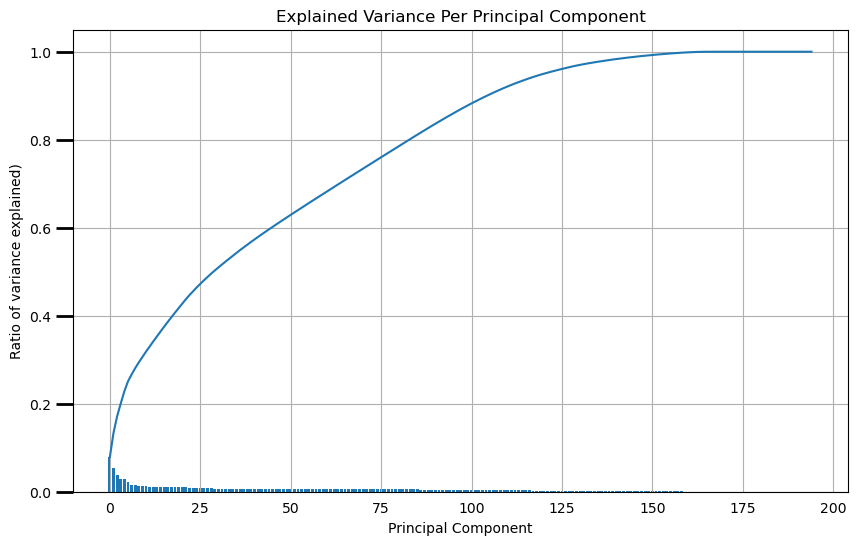

In [58]:
# scree_plot function used on the course without labels

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Ratio of variance explained)")
    plt.title('Explained Variance Per Principal Component')
    plt.grid()
# Investigate the variance accounted for by each principal component.
scree_plot(pca)


In [59]:
X = StandardScaler().fit_transform(azdias_scaled)
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
for i in np.arange(10, 101, 10):
    print('{} components explain {} of variance.'.format(i, pca.explained_variance_ratio_[:i].sum()))

10 components explain 0.3064270258156872 of variance.
20 components explain 0.41720139587103194 of variance.
30 components explain 0.502755582010454 of variance.
40 components explain 0.5674777174328156 of variance.
50 components explain 0.6237443829521543 of variance.
60 components explain 0.6767715829961216 of variance.
70 components explain 0.7287764338719105 of variance.
80 components explain 0.7801571717320697 of variance.
90 components explain 0.8303369050888872 of variance.
100 components explain 0.8764321567768883 of variance.


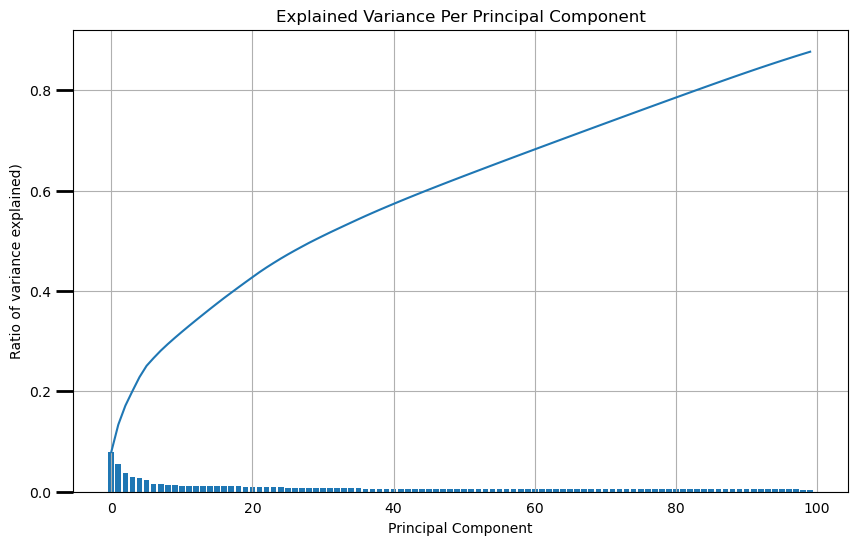

In [60]:
scree_plot(pca)


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

#### Answer
100 of component will be retained to get variance of 87%

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [61]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def get_weights(pca, feature_columns, component_number):
    component = pd.DataFrame(pca.components_, columns=list(feature_columns)).iloc[component_number-1]
    component.sort_values(ascending=False, inplace=True)
    component = pd.concat([component.head(5), component.tail(5)])
    component.plot(kind='bar', title='Most {} weighted features for PCA component {}'.format(5*2, component_number),
                  figsize=(12, 6))
    plt.show()
    return component


In [62]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
positive_values = []
negative_values = []



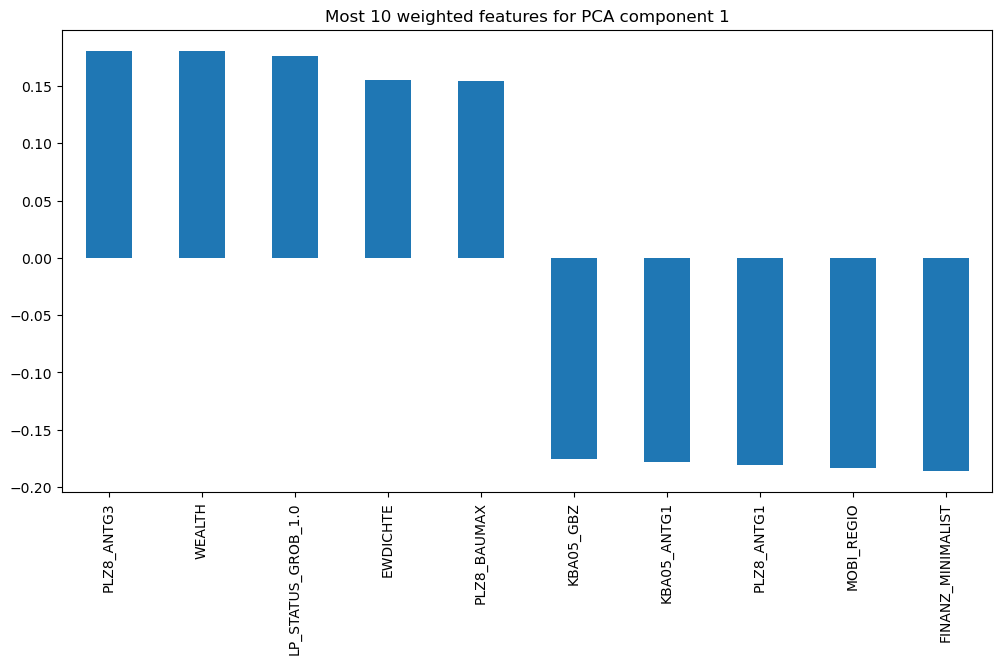

PLZ8_ANTG3            0.180804
WEALTH                0.180633
LP_STATUS_GROB_1.0    0.175914
EWDICHTE              0.155044
PLZ8_BAUMAX           0.154613
KBA05_GBZ            -0.175551
KBA05_ANTG1          -0.178304
PLZ8_ANTG1           -0.180463
MOBI_REGIO           -0.183831
FINANZ_MINIMALIST    -0.185719
Name: 0, dtype: float64

In [63]:
positive_values = []
negative_values = []

weights_1 = get_weights(pca, azdias_scaled.columns, 1)
weights_1

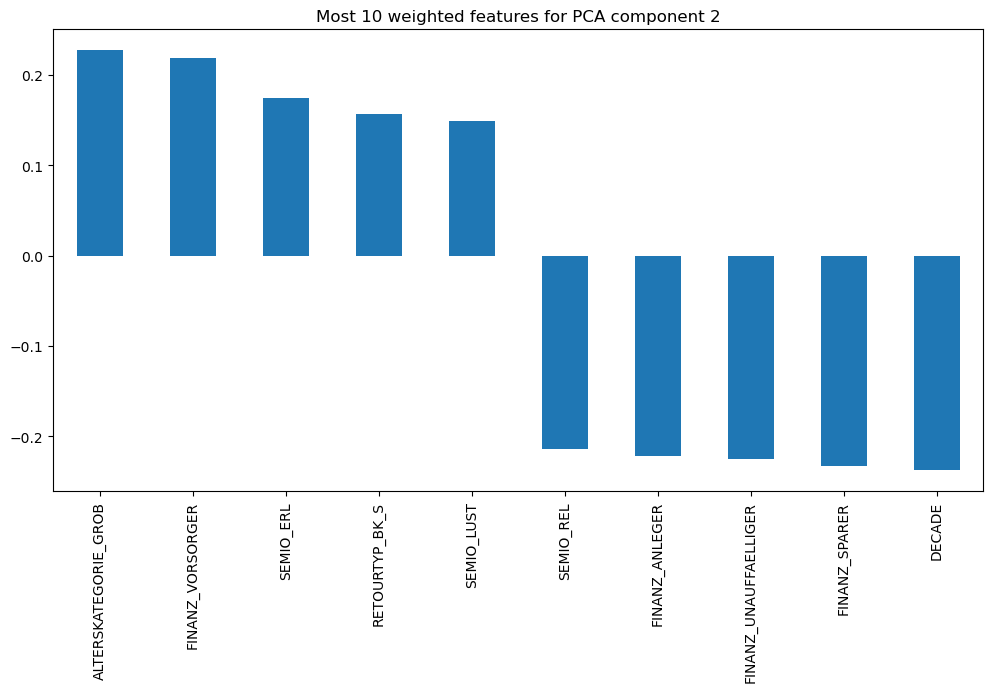

ALTERSKATEGORIE_GROB     0.227031
FINANZ_VORSORGER         0.218153
SEMIO_ERL                0.174850
RETOURTYP_BK_S           0.156330
SEMIO_LUST               0.149482
SEMIO_REL               -0.214264
FINANZ_ANLEGER          -0.221438
FINANZ_UNAUFFAELLIGER   -0.224972
FINANZ_SPARER           -0.232416
DECADE                  -0.237571
Name: 1, dtype: float64

In [64]:
weights_2 = get_weights(pca, azdias_scaled.columns, 2)
weights_2

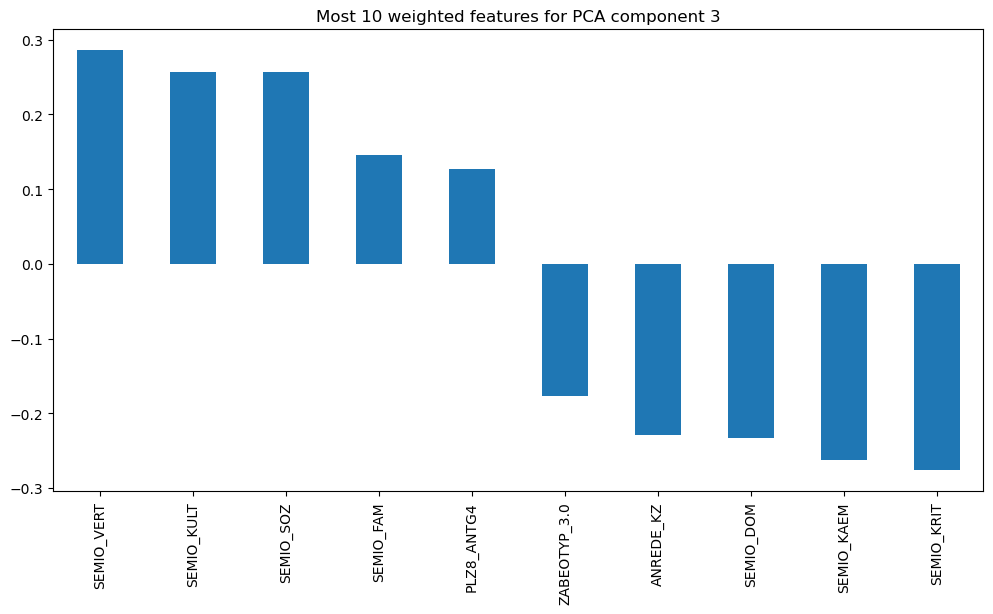

SEMIO_VERT      0.285642
SEMIO_KULT      0.257282
SEMIO_SOZ       0.256973
SEMIO_FAM       0.146115
PLZ8_ANTG4      0.126344
ZABEOTYP_3.0   -0.177391
ANREDE_KZ      -0.228754
SEMIO_DOM      -0.233361
SEMIO_KAEM     -0.263045
SEMIO_KRIT     -0.276434
Name: 2, dtype: float64

In [65]:
weights_3 = get_weights(pca, azdias_scaled.columns, 3)
weights_3

In [66]:
positive_values = weights_1.head().keys().tolist() + weights_2.head().keys().tolist() + weights_3.head().keys().tolist()
negative_values = weights_1.tail().keys().tolist() + weights_2.tail().keys().tolist() + weights_3.tail().keys().tolist()

print(positive_values)
print(negative_values)

['PLZ8_ANTG3', 'WEALTH', 'LP_STATUS_GROB_1.0', 'EWDICHTE', 'PLZ8_BAUMAX', 'ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 'SEMIO_ERL', 'RETOURTYP_BK_S', 'SEMIO_LUST', 'SEMIO_VERT', 'SEMIO_KULT', 'SEMIO_SOZ', 'SEMIO_FAM', 'PLZ8_ANTG4']
['KBA05_GBZ', 'KBA05_ANTG1', 'PLZ8_ANTG1', 'MOBI_REGIO', 'FINANZ_MINIMALIST', 'SEMIO_REL', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_SPARER', 'DECADE', 'ZABEOTYP_3.0', 'ANREDE_KZ', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_KRIT']


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

#### Answer
evaluation is done by matching data_dictionary 

Principal Component Analysis 1

The second component is influenced by houshold, surroundings, moving patterns and wealth level

Principal Component Analysis 2

The third component is influenced by age, product returns, events, savings level, openess and religiousness.

Principal Component Analysis 3

The first PCA is mostly influenced by mindsets, culture,social,dreams.

example:

 First principal component
 positive values:
 -PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region
 -WEALTH: Household wealthy
 -LP_STATUS_GROB_1.0: Social status, low-income earners
 -EWDICHTE: Density of households per square kilometer
 -PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region
 -PLZ8_BAUMAX: Most common building type within the PLZ8 region
 Negative Values:
 -FINANZ_MINIMALIST: Financial typology - low financial interest
 -KBA05_GBZ: Number of buildings in the microcell
 -PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region
 -KBA05_ANTG1: Number of 1-2 family houses in the microcell
 -MOBI_REGIO: Movement patterns


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [67]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
centers = list(range(2, 30, 2)) 
print(centers) 
scores = []
for center in centers:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(X_pca)
    
    # compute the average within-cluster distances.    
    # Obtain a score related to the model fitpd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
    score = np.abs(model.score(X_pca))
    scores.append(score)  

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]


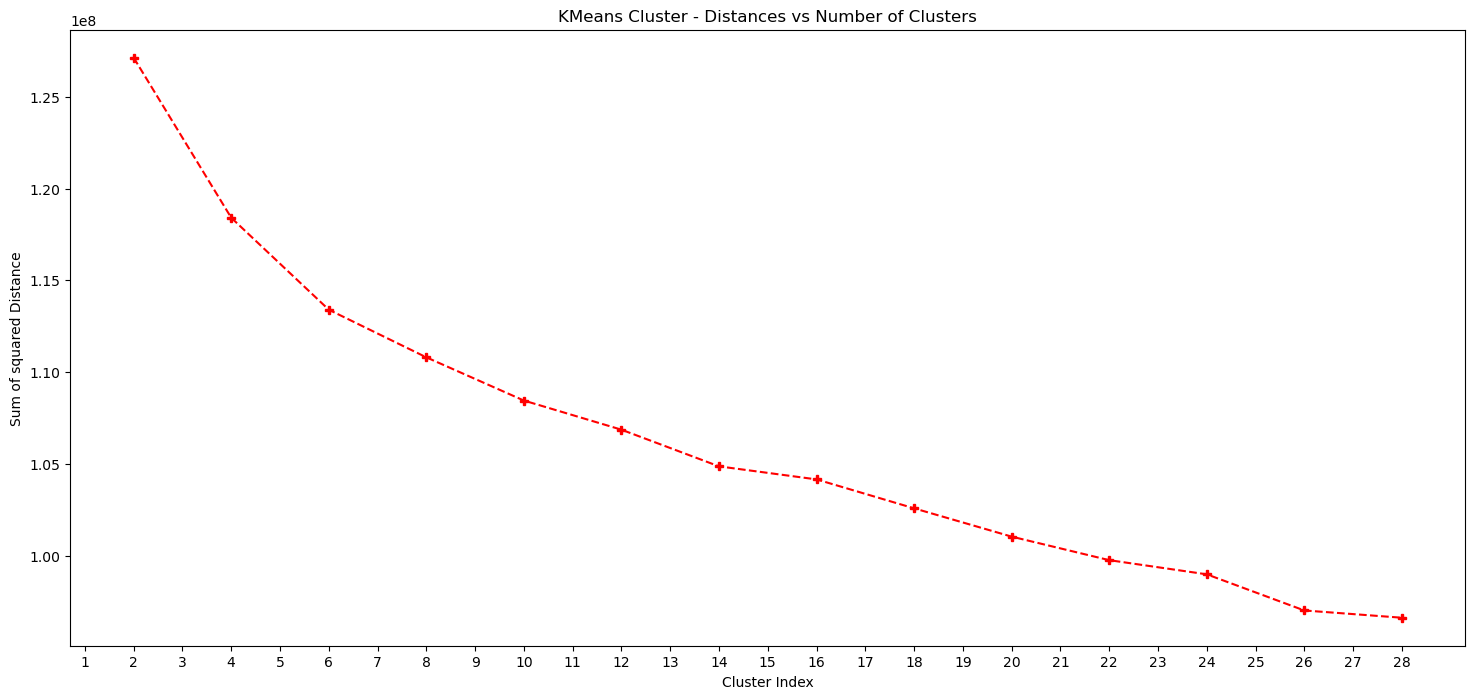

In [68]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.fig, ax = plt.subplots(figsize=(15,10))

plt.figure(figsize=(18, 8))
plt.xticks(np.arange(0, centers[-1]+1, step=1))
plt.xlabel('Cluster Index')
plt.ylabel('Sum of squared Distance')
plt.title('KMeans Cluster - Distances vs Number of Clusters')
plt.plot(centers, scores, linestyle='--',color='r',marker='P');


In [91]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=14)
model = kmeans.fit(X_pca)
population_prediction = model.predict(X_pca)

C:\Users\gagka\AppData\Local\Temp\ipykernel_29620\271334110.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


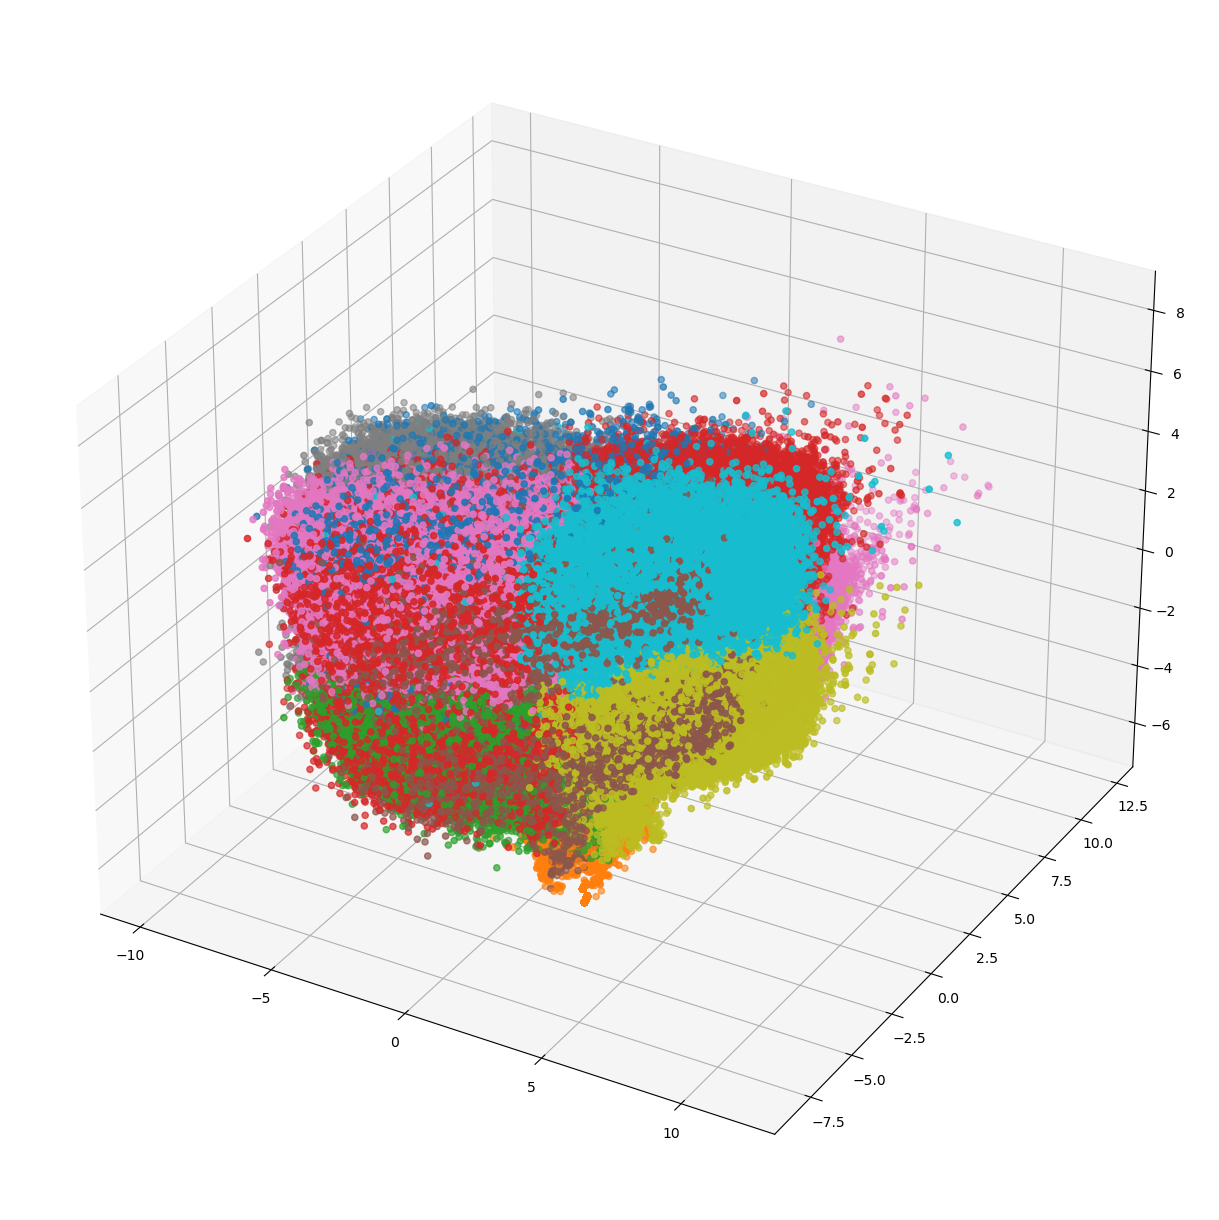

In [92]:
from mpl_toolkits.mplot3d import Axes3D
def create_kmeans_plot(data, labels): 
    fig = plt.figure(figsize=(28, 12));
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');
create_kmeans_plot(X_pca, population_prediction)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

#### Answer
30 clusters are used to create an elbow plot with KMeans to the clean population data by iterating from 2 to 28 centers. Based on the plot, I decided that 14 clusters would be an optimal amount to move forward with.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [93]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [94]:
customers

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,1,3,1,4.0,5,1,5,1,1,2,...,2.0,4.0,2.0,1.0,2.0,5.0,4.0,3.0,8.0,5.0
191648,-1,4,2,2.0,5,1,5,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0
191649,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
191650,3,3,2,4.0,2,1,5,1,2,5,...,3.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.0


In [95]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customer_data = clean_data(customers, feat_info_test)

Data cleaning has started...
2252274 null values found.
Converting nulls to NaNs...
Success!


C:\Users\gagka\AppData\Local\Temp\ipykernel_29620\3051283222.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  missing_above_30 = df[missing_row_data >= 30].reset_index(drop=True)


20148 rows greater than 30% in missing row values were dropped
171504 rows are remaining

Checking features...
Re-encoding some categorical features...


C:\Users\gagka\AppData\Local\Temp\ipykernel_29620\3051283222.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ANREDE_KZ'].replace([2.0, 1], [1.0, 0], inplace=True)
C:\Users\gagka\AppData\Local\Temp\ipykernel_29620\3051283222.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
C:\Users\gagka\AppData\Local\Temp\ipykernel_29620\3051283222.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

Success!
Engineering some mixed-type features...
Success!

Data cleaned in 0 minute(s)!


In [96]:
customer_data.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
20148,2.0,1.0,3.0,2.0,4.0,3.0,3.0,1.0,0,2.0,...,0,0,0,0,0,0,5.0,1.0,4.0,3.0
20149,1.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
20150,3.0,0.0,5.0,1.0,5.0,2.0,1.0,2.0,0,3.0,...,0,0,0,0,0,0,3.0,1.0,2.0,5.0
20151,3.0,0.0,5.0,1.0,5.0,1.0,2.0,2.0,1,3.0,...,0,0,0,0,0,0,3.0,0.0,1.0,2.0
20152,4.0,1.0,5.0,1.0,5.0,2.0,1.0,3.0,0,1.0,...,0,0,0,0,0,0,4.0,1.0,1.0,2.0


In [97]:
customer_columns = customer_data.columns
customer_imputer = imputer.transform(customer_data)
customer_imputer = pd.DataFrame(customer_imputer, columns=customer_columns)
customer_imputer.isnull().sum().sum()

0

In [98]:
customer_imputer

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1.0,3.0,2.0,4.0,3.0,3.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,4.0,3.0
1,1.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,5.0,1.0
2,3.0,0.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,5.0
3,3.0,0.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,2.0
4,4.0,1.0,5.0,1.0,5.0,2.0,1.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171499,3.0,0.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,4.0
171500,4.0,1.0,5.0,1.0,5.0,2.0,2.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,2.0
171501,4.0,0.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0
171502,3.0,1.0,2.0,1.0,5.0,1.0,2.0,5.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,4.0


In [99]:
customer_scaled = scaler.transform(customer_imputer)
customer_scaled = pd.DataFrame(customer_scaled, columns=customer_columns)
customer_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-0.751868,0.957179,-0.058769,-0.559024,0.453026,-0.021158,0.085488,-1.530689,-0.495175,-0.384047,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,0.316430,0.495175,0.368038,0.219722
1,-1.743065,0.957179,-0.058769,0.806168,-0.302845,1.286746,1.430933,-0.053970,-0.495175,0.939358,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,0.995338,0.495175,1.041416,-1.097205
2,0.239328,-1.044737,1.454051,-1.241620,1.208897,-0.675111,-1.259957,-0.792330,-0.495175,0.939358,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,-1.041386,0.495175,-0.978716,1.536649
3,0.239328,-1.044737,1.454051,-1.241620,1.208897,-1.329063,-0.587234,-0.792330,2.019490,0.939358,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,-1.041386,-2.019490,-1.652094,-0.438742
4,1.230525,0.957179,1.454051,-1.241620,1.208897,-0.675111,-1.259957,-0.053970,-0.495175,-1.707451,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,-0.362478,0.495175,-1.652094,-0.438742


In [100]:
customers_pca = pca.transform(customer_scaled)


C:\Users\gagka\OneDrive\Attachments\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


customers_imputer = imputer.transform(customers_clean)
customers_normalize = scaler.transform(customers_imputer)
customers_pca = pca.transform(customers_normalize)
customer_clusters = kmeans.predict(customers_pca)

C:\Users\gagka\AppData\Local\Temp\ipykernel_29620\271334110.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


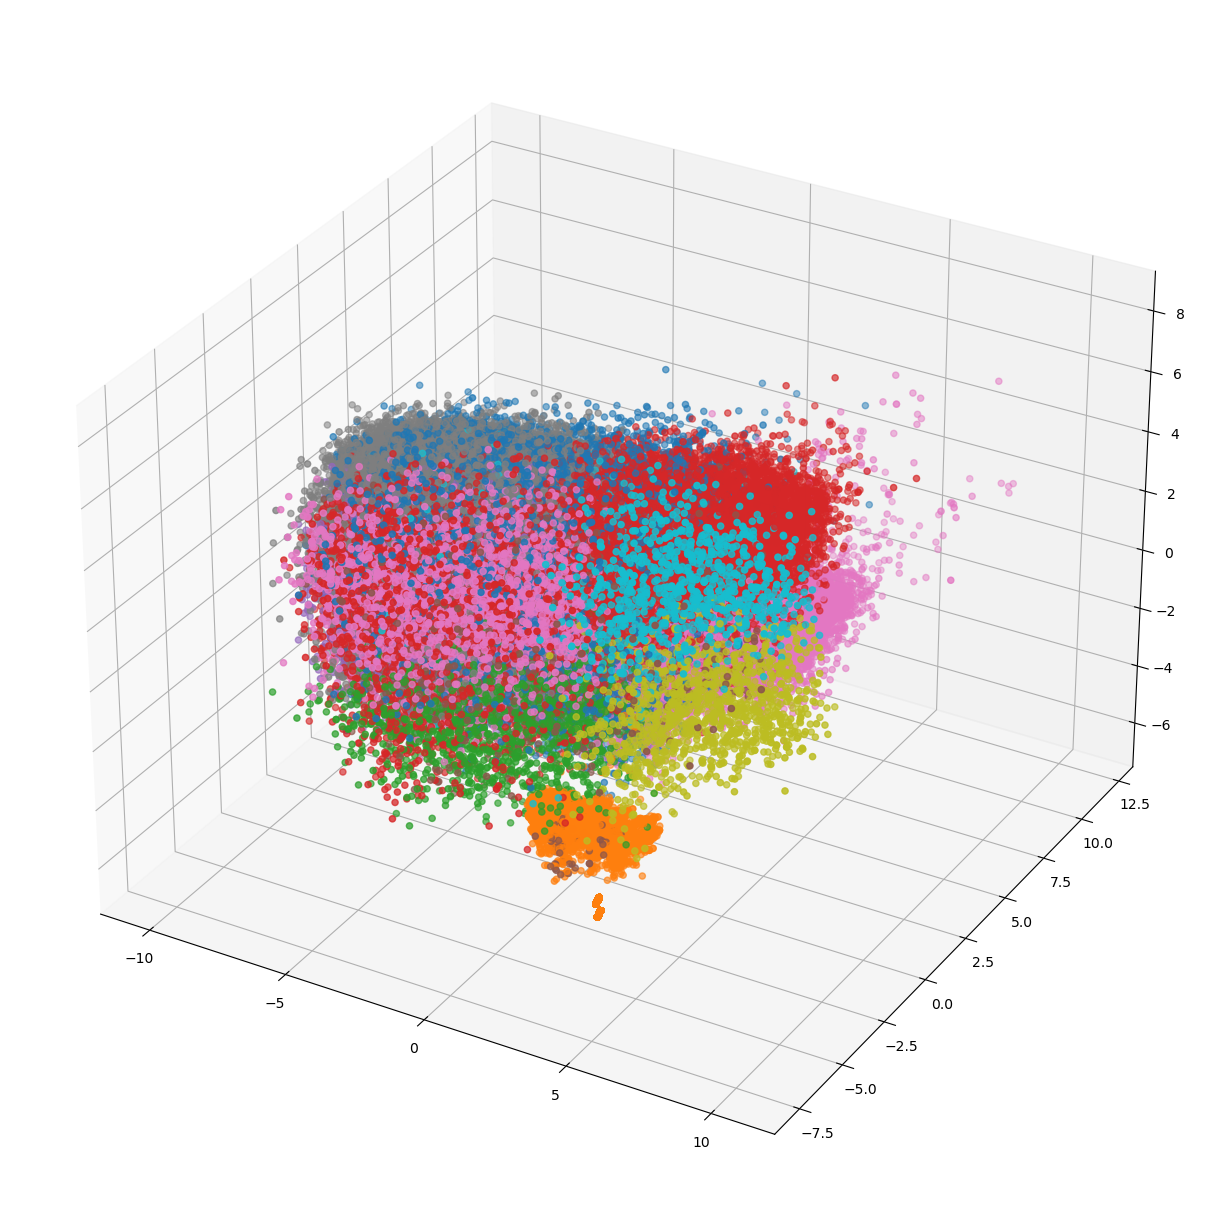

In [101]:
#cluster predictions
customer_prediction= model.predict(customers_pca)
create_kmeans_plot(customers_pca, customer_prediction)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [102]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

clusterno_predicted_general = pd.Series(population_prediction).value_counts().sort_index()

clusterno_predicted_customers = pd.Series(customer_prediction).value_counts().sort_index()

df_both = pd.concat([clusterno_predicted_general, clusterno_predicted_customers], axis=1).reset_index()
df_both.columns = ['clusters', 'pred_general', 'pred_customers']

df_both

,clusters,pred_general,pred_customers
0,0,30815,13758
1,1,63546,9960
2,2,65416,41490
3,3,59002,1274
4,4,36516,5604
5,5,87823,12968
6,6,92430,25347
7,7,25578,1257
8,8,49355,2268
9,9,74836,10195


In [103]:
# calculating proportions of persons in both customer and general data
df_both['general_prop'] = (df_both['pred_general']/df_both['pred_general'].sum()*100).round(3)
df_both['customers_prop'] = (df_both['pred_customers']/df_both['pred_customers'].sum()*100).round(3)

# calculating the diferences between the two proportions
df_both['difference'] = df_both['general_prop'] - df_both['customers_prop']
df_both

,clusters,pred_general,pred_customers,general_prop,customers_prop,difference
0,0,30815,13758,3.861,8.022,-4.161
1,1,63546,9960,7.963,5.807,2.156
2,2,65416,41490,8.197,24.192,-15.995
3,3,59002,1274,7.393,0.743,6.650
4,4,36516,5604,4.576,3.268,1.308
5,5,87823,12968,11.005,7.561,3.444
6,6,92430,25347,11.582,14.779,-3.197
7,7,25578,1257,3.205,0.733,2.472
8,8,49355,2268,6.184,1.322,4.862
9,9,74836,10195,9.377,5.944,3.433


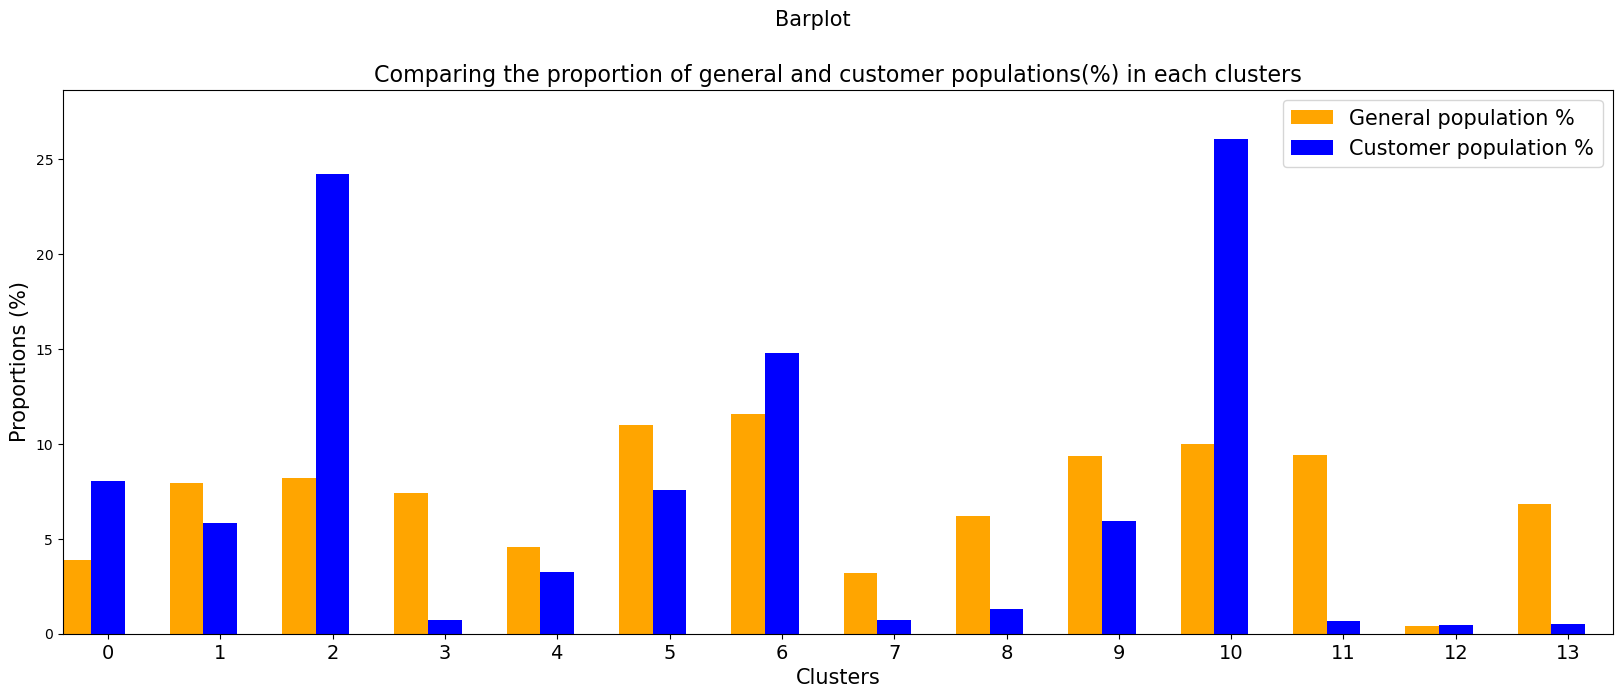

In [104]:
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(1,1,1)

ax = df_both['general_prop'].plot(x=df_both['clusters'], kind='bar',color='orange',width=-0.3, align='edge',position=0)
ax = df_both['customers_prop'].plot(x=df_both['clusters'], kind='bar',color='blue',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Proportions (%)', fontsize=15)
ax.tick_params(axis = 'x', which = 'major', labelsize = 14)
plt.xticks(rotation=360,)

plt.legend(('General population %', 'Customer population %'),fontsize=15)
plt.title('Comparing the proportion of general and customer populations(%) in each clusters',fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.suptitle("Barplot", fontsize=15)
plt.show()

In [105]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

overrepresented_customers = scaler.inverse_transform([pca.inverse_transform(model.cluster_centers_[3])]).round(0)
overrepresented_customers_df=pd.DataFrame({"feature":azdias_scaled.columns, "overrepresented_customers":overrepresented_customers[0]})
overrepresented_customers_df

,feature,overrepresented_customers
0,ALTERSKATEGORIE_GROB,2.0
1,ANREDE_KZ,1.0
2,FINANZ_MINIMALIST,2.0
3,FINANZ_SPARER,4.0
4,FINANZ_VORSORGER,2.0
...,...,...
190,CAMEO_DEU_2015_9E,0.0
191,DECADE,6.0
192,MOVEMENT,1.0
193,WEALTH,3.0


In [106]:
overrepresented_customers_df[overrepresented_customers_df["feature"].isin(positive_values)]


,feature,overrepresented_customers
0,ALTERSKATEGORIE_GROB,2.0
4,FINANZ_VORSORGER,2.0
12,RETOURTYP_BK_S,2.0
13,SEMIO_SOZ,3.0
14,SEMIO_FAM,4.0
17,SEMIO_VERT,3.0
18,SEMIO_LUST,3.0
19,SEMIO_ERL,4.0
20,SEMIO_KULT,4.0
46,EWDICHTE,3.0


In [107]:
overrepresented_customers_df[overrepresented_customers_df["feature"].isin(negative_values)]


,feature,overrepresented_customers
1,ANREDE_KZ,1.0
2,FINANZ_MINIMALIST,2.0
3,FINANZ_SPARER,4.0
5,FINANZ_ANLEGER,4.0
6,FINANZ_UNAUFFAELLIGER,4.0
15,SEMIO_REL,5.0
22,SEMIO_KRIT,6.0
23,SEMIO_DOM,6.0
24,SEMIO_KAEM,6.0
40,KBA05_ANTG1,2.0


In [108]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented_customers = scaler.inverse_transform([pca.inverse_transform(model.cluster_centers_[9])]).round(0)
underrepresented_customers_df=pd.DataFrame({"feature":azdias_scaled.columns, "underrepresented_customers":underrepresented_customers[0]})

underrepresented_customers_df

,feature,underrepresented_customers
0,ALTERSKATEGORIE_GROB,4.0
1,ANREDE_KZ,1.0
2,FINANZ_MINIMALIST,3.0
3,FINANZ_SPARER,2.0
4,FINANZ_VORSORGER,4.0
...,...,...
190,CAMEO_DEU_2015_9E,0.0
191,DECADE,3.0
192,MOVEMENT,1.0
193,WEALTH,4.0


In [109]:
underrepresented_customers_df[underrepresented_customers_df["feature"].isin(positive_values)]


,feature,underrepresented_customers
0,ALTERSKATEGORIE_GROB,4.0
4,FINANZ_VORSORGER,4.0
12,RETOURTYP_BK_S,4.0
13,SEMIO_SOZ,3.0
14,SEMIO_FAM,2.0
17,SEMIO_VERT,3.0
18,SEMIO_LUST,5.0
19,SEMIO_ERL,6.0
20,SEMIO_KULT,2.0
46,EWDICHTE,5.0


In [110]:
underrepresented_customers_df[underrepresented_customers_df["feature"].isin(negative_values)]


,feature,underrepresented_customers
1,ANREDE_KZ,1.0
2,FINANZ_MINIMALIST,3.0
3,FINANZ_SPARER,2.0
5,FINANZ_ANLEGER,2.0
6,FINANZ_UNAUFFAELLIGER,2.0
15,SEMIO_REL,2.0
22,SEMIO_KRIT,6.0
23,SEMIO_DOM,6.0
24,SEMIO_KAEM,6.0
40,KBA05_ANTG1,0.0


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)
KMean model is created using unsupervised learning.Data is separated into clusters.PCA helped to reduce the dimensionality.

We applied it to the general population, then to the customer population and finally compared the resulting data getting conclusions of overrepresented data and underrepresented customer clusters data.

Cluster 3 is overrepresented in the customers data compared to general population data. Some characteristics of the group of population that are relative popular with the mail-order company:

-in areas where the share of 6-10 family homes is lower (PLZ8_ANTG3)
-in Prosperous or Comfortable households (WEALTH)
-Financial typology prepared(FINANZ_VORSORGER)
This segment is relatively popular with the mail-order sales company.


Cluster 9 is underrepresented in the customers data. Some characteristics of the segment of the population that are relatively unpopular with the company:

-Estimated age based on given name analysis(ALTERSKATEGORIE_GROB)
-determine Return type :influenceable Crazy-Shopper,demanding Heavy-Returner,incentive-receptive Normal-Returner(RETOURTYP_BK_S)
-Number of 1-2 family houses in the microcell.(KBA05_ANTG1)
This segment is unpopular in mail-orders sales with the company, probably because they're heavy-returners, low income and live in less affluent households.




> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.